# Create lithogenic and biogenic particle fields for Pb scavenging

BLING ends in April, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
from scipy.spatial import Delaunay
from scipy import ndimage as nd
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

#### Load files

In [3]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM151/'
dset          = xr.open_dataset(f'/data/brogalla/ANHA4/BLING-EPM151/ANHA4-EPM151_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values

In [5]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

In [6]:
# interpolate from ANHA4 to ANHA12 grid:
tri = Delaunay(np.array([ANHA4_lons.flatten(), ANHA4_lats.flatten()]).transpose())  # Compute the triangulation

#### Functions:

In [7]:
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

In [8]:
def save_file(folder, oMn, fpop, fpops, biom, year, month):   
    
    file_write = xr.Dataset(
        {'oxidisMn' : (("deptht","y","x"), oMn),
         'fpop'     : (("deptht","y","x"), fpop),
         'fpop-sink': (("deptht","y","x"), fpops),
         'biomass'  : (("deptht","y","x"), biom)},
        coords = {
            "time_counter": np.zeros(1),
            "deptht": depths,
            "y": np.zeros(mesh_lat[imin:imax,jmin:jmax].shape[0]),
            "x": np.zeros(mesh_lon[imin:imax,jmin:jmax].shape[1])},
    )
    file_write.to_netcdf(f'{folder}Pb_scavenging_y{year}m{month:02}.nc', \
                         unlimited_dims='time_counter')

    return

In [9]:
def load_bio(year, month):
    # BLING:
    file_EPM101  = f'/data/brogalla/ANHA4/BLING-EPM151/ANHA4-EPM151_y{year}m{month:02}.nc'
    
    with xr.open_dataset(f'{file_EPM101}') as dset_bio:
        fpop_ANHA4   = dset_bio['fpop'][:,:,:].values      # sinking particulate organic matter in phosphate units (mol P/m3)
        fpop_ANHA4[fpop_ANHA4 < 0]       = 0
        fpop_ANHA4[np.isnan(fpop_ANHA4)] = np.nanmean(fpop_ANHA4)

        # Convert sinking particulate organic matter in phosphate units by dividing by the sinking rate:
        # Sinking rate info comes from pg. 43-44 Laura Castro de la Guardia's thesis, same as BLING general paper
        wsink              = np.ones(ANHA4_depths.shape)*16/(3600*24) # convert from m/day to m/s
        wsink[depths > 80] = (0.05*(ANHA4_depths[ANHA4_depths > 80]-80)+16)/(3600*24) 
        fpops_ANHA4        = np.array([fpop_ANHA4[d,:,:] / wsink[d] for d in range(0,len(ANHA4_depths))])
        fpops_ANHA4[fpop_ANHA4 < 0]       = 0
        fpops_ANHA4[np.isnan(fpop_ANHA4)] = np.nanmean(fpops_ANHA4)

        biop_ANHA4   = dset_bio['biomass_p'][:,:,:].values # biomass concentration in phosphate units (mol P/m3)
        biop_ANHA4[biop_ANHA4 < 0]       = 0
        biop_ANHA4[np.isnan(biop_ANHA4)] = np.nanmean(biop_ANHA4)
        
        return fpop_ANHA4, fpops_ANHA4, biop_ANHA4

def interpolate_bio(bio_particles):
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_bio = np.empty((50,isize,jsize))
    for depth in range(0,50):
        interpolator   = LinearNDInterpolator(tri, bio_particles[depth,:,:].flatten())    
    
        ANHA12_bio[depth,:,:] = interpolator(np.array([ANHA12_lons.flatten(), ANHA12_lats.flatten()]).transpose()).reshape(ANHA12_lons.shape)

    return ANHA12_bio

def load_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    
    with xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc') as dset_ANHA12:
        ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 

    return ANHA12_Mn

In [10]:
def create_particle_fields(year, month, save=False, loc=''):
    
    # load forcing fields and interpolate to ANHA12 grid
    ANHA4_fpop, ANHA4_fpops, ANHA4_biom = load_bio(year, month)
    ANHA12_fpop  = interpolate_bio(ANHA4_fpop)
    ANHA12_fpops = interpolate_bio(ANHA4_fpops)
    ANHA12_biom  = interpolate_bio(ANHA4_biom)
    ANHA12_litho = load_litho(year, month)

    # Fill any weird values 
    # https://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
    ANHA12_biom  = fill(ANHA12_biom,  invalid=(ANHA12_biom  < 0))
    ANHA12_fpop  = fill(ANHA12_fpop,  invalid=(ANHA12_fpop  < 0))
    ANHA12_fpops = fill(ANHA12_fpops, invalid=(ANHA12_fpops < 0))
    ANHA12_litho = fill(ANHA12_litho, invalid=(ANHA12_litho < 0))
    ANHA12_biom[np.isnan(ANHA12_biom)]   = 0.0; ANHA12_fpop[np.isnan(ANHA12_fpop)]   = 0.0;
    ANHA12_fpops[np.isnan(ANHA12_fpops)] = 0.0; ANHA12_litho[np.isnan(ANHA12_litho)] = 0.0;
    ANHA12_biom[(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1)]  = 0.0; ANHA12_fpop[(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1)]  = 0.0;
    ANHA12_litho[(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1)] = 0.0; ANHA12_fpops[(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1)] = 0.0; 
    
    if save:
        folder =f'/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/{loc}'
        save_file(f'{folder}', ANHA12_litho, ANHA12_fpop, ANHA12_fpops, ANHA12_biom, year, month)
    
    return ANHA12_litho, ANHA12_biom

#### Calculations

Create particle fields and save:

In [11]:
for year in range(2006, 2022):
    for month in range(1,13):
        print(year, month)
        litho, bio = create_particle_fields(year, month, save=True, loc = 'particle-fields/')

2006 1
2006 2
2006 3
2006 4
2006 5
2006 6
2006 7
2006 8
2006 9
2006 10
2006 11
2006 12
2007 1
2007 2
2007 3
2007 4
2007 5
2007 6
2007 7
2007 8
2007 9
2007 10
2007 11
2007 12
2008 1
2008 2
2008 3
2008 4
2008 5
2008 6
2008 7
2008 8
2008 9
2008 10
2008 11
2008 12
2009 1
2009 2
2009 3
2009 4
2009 5
2009 6
2009 7
2009 8
2009 9
2009 10
2009 11
2009 12
2010 1
2010 2
2010 3
2010 4
2010 5
2010 6
2010 7
2010 8
2010 9
2010 10
2010 11
2010 12
2011 1
2011 2
2011 3
2011 4
2011 5
2011 6
2011 7
2011 8
2011 9
2011 10
2011 11
2011 12
2012 1
2012 2
2012 3
2012 4
2012 5
2012 6
2012 7
2012 8
2012 9
2012 10
2012 11
2012 12
2013 1
2013 2
2013 3
2013 4
2013 5
2013 6
2013 7
2013 8
2013 9
2013 10
2013 11
2013 12
2014 1
2014 2
2014 3
2014 4
2014 5
2014 6
2014 7
2014 8
2014 9
2014 10
2014 11
2014 12
2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
2016 7
2016 8
2016 9
2016 10
2016 11
2016 12
2017 1
2017 2
2017 3
2017 4
2017 5
2017 6
2

In [48]:
d = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202302/fpops-biom-b001-p015/Pb_scavenging_y2002m09.nc')
part = d['particles'].values

In [49]:
print(np.amax(part[:,imin:imax,jmin:jmax]), np.amin(part[:,imin:imax,jmin:jmax]), np.mean(part[:,imin:imax,jmin:jmax]))

0.8785949189427935 0.0 0.12173900027079215


#### Extra: compare ANHA4 original field and interpolated field:
Look basically the same (except for ANHA4 grid artefact thingy

In [43]:
year=2002; month=8;
file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
dset_bio    = xr.open_dataset(f'{file_EPM101}')
biop_ANHA4  = dset_bio['biomass_p'][:,:,:].values
fpop_ANHA4  = dset_bio['fpop'][:,:,:].values
jpop_ANHA4  = dset_bio['jp_pop'][:,:,:].values
    
wsink              = np.ones(depths.shape)*16/(3600*24) # convert from m/day to m/s
wsink[depths > 80] = (0.05*(depths[depths > 80]-80)+16)/(3600*24) 

fpop_ANHA4         = np.array([fpop_ANHA4[d,:,:] / wsink[d] for d in range(0,len(depths))])
jpop_ANHA4         = np.array([jpop_ANHA4[d,:,:] / wsink[d] for d in range(0,len(depths))])

biogenic = biop_ANHA4 + fpop_ANHA4

In [44]:
print(np.nanmax(bio))

0.0005970495985820888


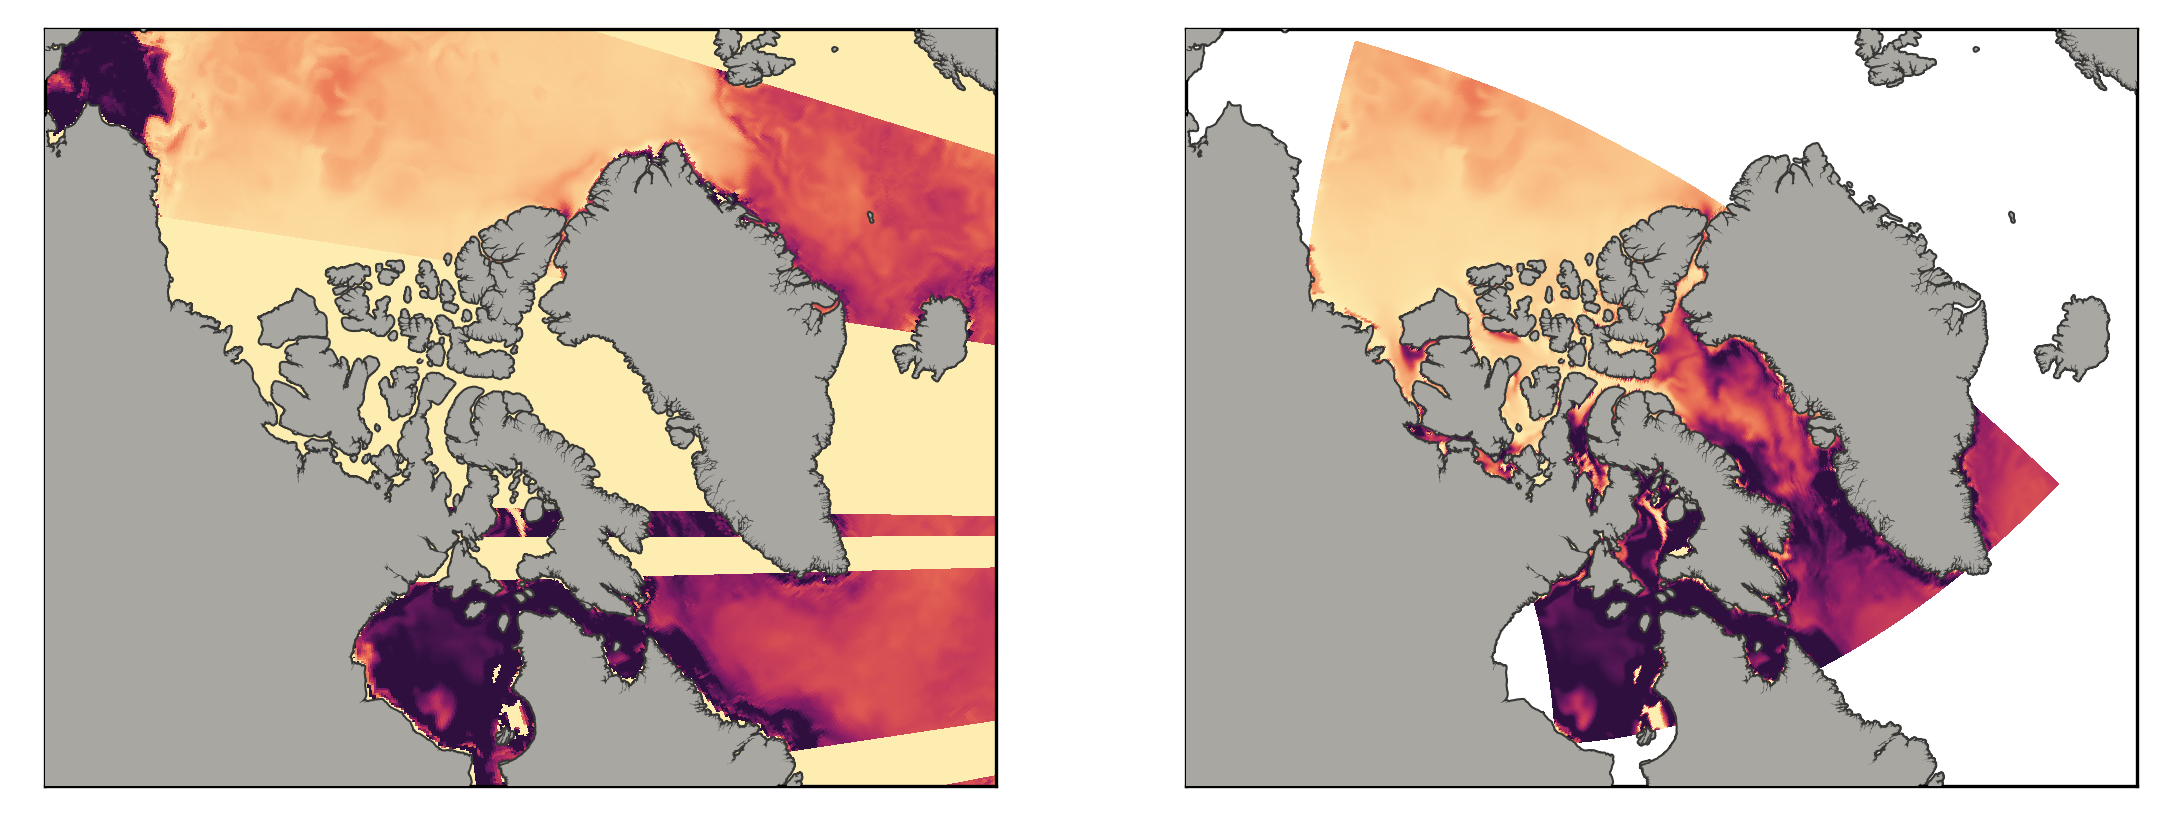

In [45]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

# CB1 = proj1.contourf(xANHA4, yANHA4, pop_ANHA4[30,:,:], levels=100, cmap=cmocean.cm.matter, vmin=0, vmax=1e-6)
CB1 = proj1.pcolormesh(xANHA4, yANHA4, biogenic[10,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-4)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[10,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-4)

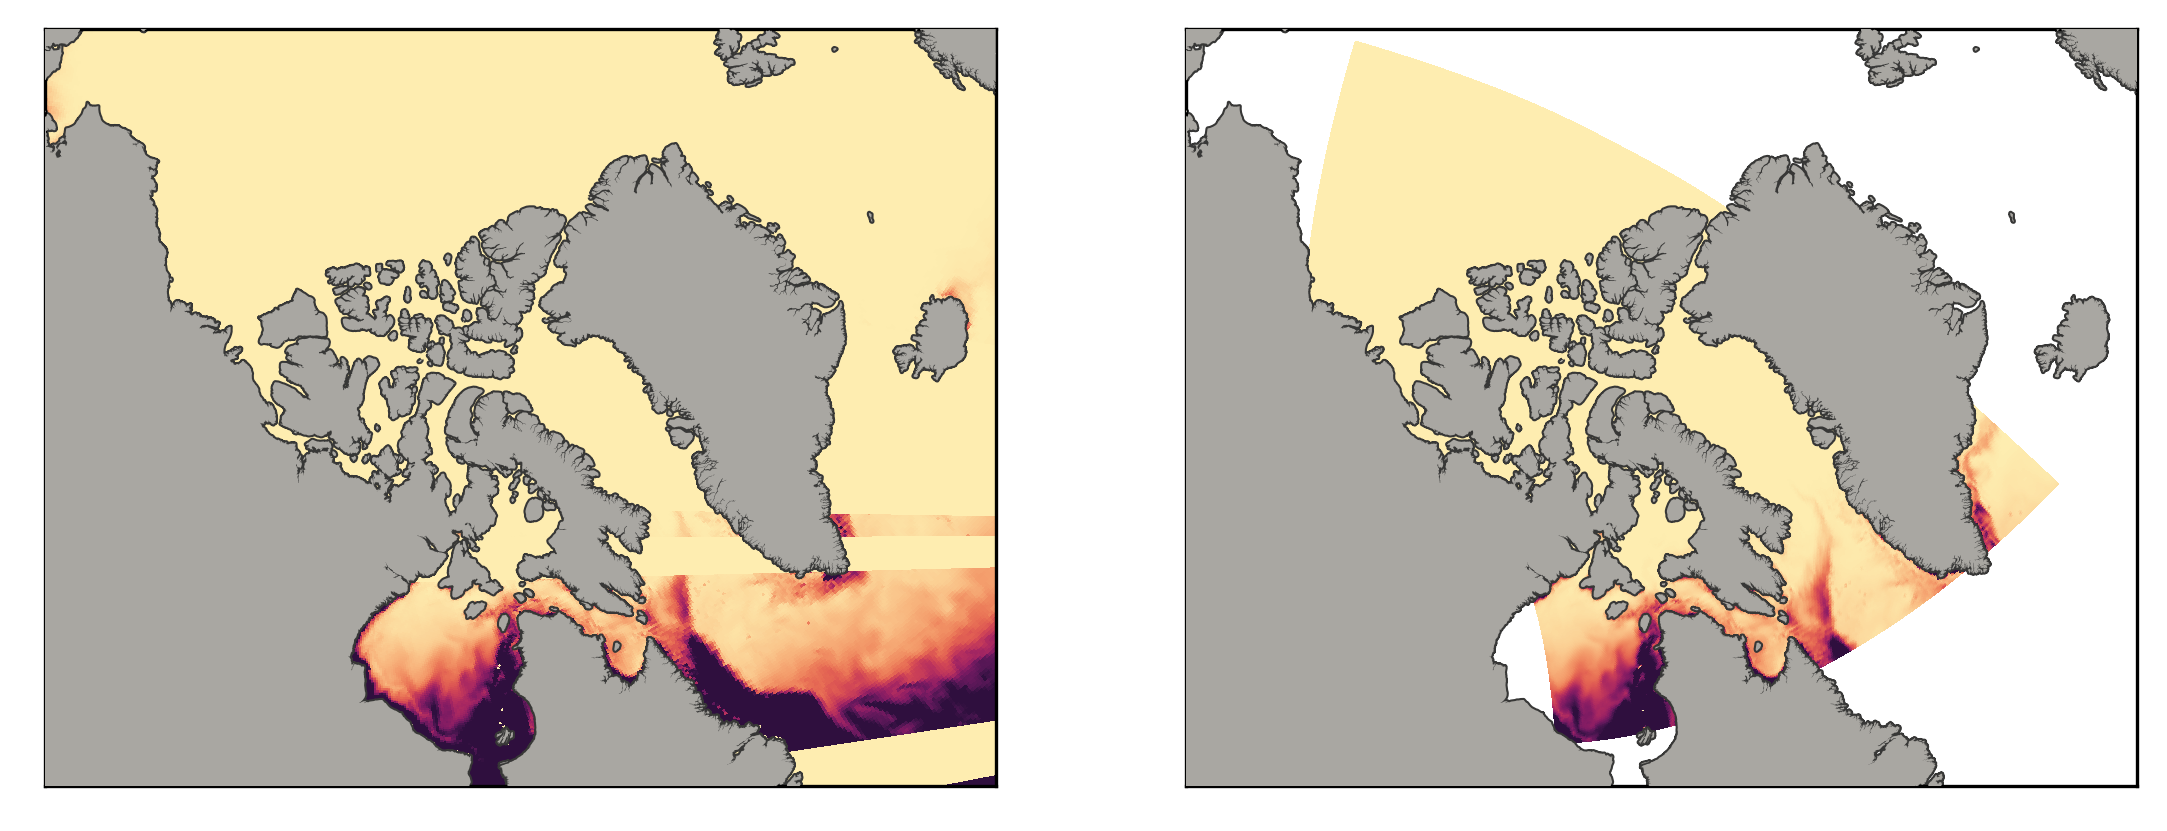

In [64]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

# CB1 = proj1.contourf(xANHA4, yANHA4, pop_ANHA4[0,:,:], levels=100, cmap=cmocean.cm.matter, vmin=0, vmax=1e-6)
CB1 = proj1.pcolormesh(xANHA4, yANHA4, pop_ANHA4[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-7)